## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
import sys
sys.path.append('..')
from src.image_utils import *
from src.spectral_variables import *

def get_tree(basefolder, ws, filename, delin=''):
    tree = np.load(f'{basefolder}{ws}m{delin}/{filename}')
    return tree

vmin = (0.133166, 0.128009, 0)
vmax = (13.0125, 10.3163, 7.1825)

# Training and validation data generation

Instead of doing random split for training and validation data, we split on tiling columns, using columns 19-22 as valiadtion set. This is done in order to prevent data leakage from training set to validation set, especially in the case of 3D CNNs. 

We also use only non-interpolated and non-noisy spectral bands as our data.

Tile R8C22 is dropped due to field plot being located just outside of hyperspectral data area.

In [3]:
data = gpd.read_file('../data/labeled_tiles_fixed/matched_trees.shp')
data = data[data.species != 'Other']
data = data[data.tile_id != 'R8C22']
data.species.value_counts()

Scots pine        1099
Norway spruce      721
Birch              563
European aspen     443
Name: species, dtype: int64

In [4]:
data[data.is_gps == 1].species.value_counts()

Scots pine        449
European aspen    424
Birch             304
Norway spruce     258
Name: species, dtype: int64

In [5]:
data[data.is_gps == 0].species.value_counts()

Scots pine        650
Norway spruce     463
Birch             259
European aspen     19
Name: species, dtype: int64

"Detection rates" are the following:

In [6]:
field_data = gpd.read_file('../data/field_data/all_trees_dbh_150_dec_2019.shp')
field_data = field_data[field_data.species != 'Other']
field_data.species.value_counts()

Scots pine        2570
Norway spruce     2045
Birch             1267
European aspen     717
Name: species, dtype: int64

For single tree measurements:

In [7]:
for s in field_data.species.unique():
    temp_field = field_data[field_data.species == s]
    temp_match = data[data.species == s]
    gps_pct = len(temp_match[temp_match.is_gps == 1]) / len(temp_field[temp_field.is_gps == 1])
    print(f'{s}: {gps_pct}')
print(f'Overall: {len(data[data.is_gps == 1])/len(field_data[field_data.is_gps == 1])}')

Scots pine: 0.6526162790697675
Norway spruce: 0.5212121212121212
Birch: 0.6413502109704642
European aspen: 0.7078464106844741
Overall: 0.6360815602836879


For field plots:

In [8]:
for s in field_data.species.unique():
    temp_field = field_data[field_data.species == s]
    temp_match = data[data.species == s]
    gps_pct = len(temp_match[temp_match.is_gps == 0]) / len(temp_field[temp_field.is_gps == 0])
    print(f'{s}: {gps_pct}')
print(f'Overall: {len(data[data.is_gps == 0])/len(field_data[field_data.is_gps == 0])}')

Scots pine: 0.34537725823591925
Norway spruce: 0.29870967741935484
Birch: 0.3266078184110971
European aspen: 0.16101694915254236
Overall: 0.32028551692378543


Overall:

In [9]:
for s in field_data.species.unique():
    temp_field = field_data[field_data.species == s]
    temp_match = data[data.species == s]
    gps_pct = len(temp_match) / len(temp_field)
    print(f'{s}: {gps_pct}')
print(f'Overall: {len(data)/len(field_data)}')

Scots pine: 0.42762645914396885
Norway spruce: 0.35256723716381416
Birch: 0.44435674822415155
European aspen: 0.6178521617852162
Overall: 0.42824670404606757


In [10]:
from itertools import product
testtiles = [f'R{r}C{c}' for r, c in product(range(1, 24), range(19,23))]

In [11]:
train_X = data[~data.tile_id.isin(testtiles)].copy()
test_X = data[data.tile_id.isin(testtiles)].copy()
train_X.shape, test_X.shape

((2291, 18), (535, 18))

In [12]:
train_X.species.value_counts()

Scots pine        929
Norway spruce     513
Birch             488
European aspen    361
Name: species, dtype: int64

In [13]:
train_X.species.value_counts(normalize=True)

Scots pine        0.405500
Norway spruce     0.223920
Birch             0.213007
European aspen    0.157573
Name: species, dtype: float64

In [14]:
test_X.species.value_counts()

Norway spruce     208
Scots pine        170
European aspen     82
Birch              75
Name: species, dtype: int64

In [15]:
test_X.species.value_counts(normalize=True)

Norway spruce     0.388785
Scots pine        0.317757
European aspen    0.153271
Birch             0.140187
Name: species, dtype: float64

# Reference methods

Reference methods use mean and standard deviation within segmented tree crown area for each band as their input. 

These data is then normalized to have zero-mean and unit variance for each spectral channel.

# 3D CNNs

We used image patch -based classification with our CNNs. We extracted square patches centered around the detected treetop with various diameters (4m, 6m, 8m and 10m), with the true label being the corresponding treetop. 

In the case a tree is located near the edge such that it's not possible to extract square image patch, then that tree was discarded from training and validation process. However, when we classified the full area, these situations were handled by mirroring the input values in order to get square patches. 

Examples of different sized patches are presented here:

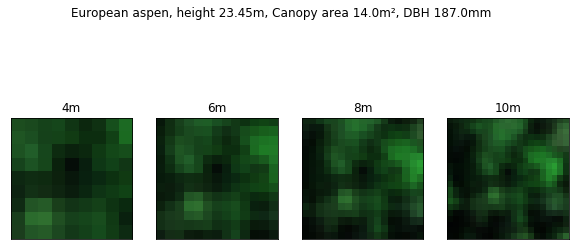

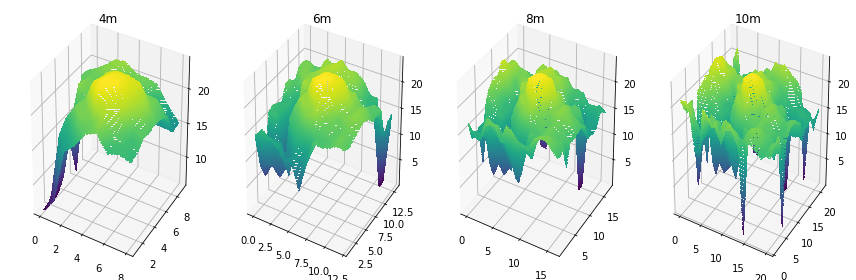

In [16]:
tree_id = np.random.randint(2800)
field_plots = gpd.read_file('../data/tree_cubes_10m_fixed/5m/matched_trees.shp')
images = [get_tree('../data/tree_cubes_10m_odd/', ws, field_plots.iloc[tree_id].filename) for ws in range(2,6)]

titles = ['4m', '6m', '8m', '10m']
fig, axs = plt.subplots(1,4,figsize=(10,5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(scale_image(images[i], channels=(82,49,28), vmin=vmin, vmax=vmax))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])
plt.suptitle(f'{field_plots.iloc[tree_id].species}, height {field_plots.iloc[tree_id].Height_m}m, Canopy area {field_plots.iloc[tree_id].CA_m2}m², DBH {field_plots.iloc[tree_id].dbh}mm')
fig = plt.figure(figsize=(12,4))
axs = [fig.add_subplot(1,4,i, projection='3d') for i in range(1,5)]
for i, ax in enumerate(axs):
    plot_chm_contour(images[i][-1], ax)
    ax.set_title(titles[i])
fig.tight_layout()


# Average spectra and means

We need the mean and standard deviation of our **training set** for data normalization. For refenrence methods we can just use `sklearn.preprocessing.StandardScaler`, but for 3D CNNs we calculate them beforehand. Here's an example for 2m windows.

In [27]:
ws = '2m'
train_x = gpd.read_file('../data/tree_cubes_10m_fixed/2m/matched_trees.shp')
train_x = train_x[~train_x.tile_id.isin(testtiles)]
train_x = train_x[train_x.species != 'Other']
train_x.reset_index(drop=True, inplace=True)

In [28]:
train_x.shape

(2270, 18)

In [30]:
data_cubes = np.array([np.load(f'../data/tree_cubes_10m_fixed/{ws}/{i}') for i in train_x['filename']])
aspen_values = data_cubes[train_x[train_x['species'] == 'European aspen'].index.values]
pine_values = data_cubes[train_x[train_x['species'] == 'Scots pine'].index.values]
spruce_values = data_cubes[train_x[train_x['species'] == 'Norway spruce'].index.values]
birch_values = data_cubes[train_x[train_x['species'] == 'Birch'].index.values]

In [31]:
aspen_means = np.nanmean(aspen_values[:,:-1,:,:], axis=(0,2,3))
pine_means = np.nanmean(pine_values[:,:-1,:,:], axis=(0,2,3))
spruce_means = np.nanmean(spruce_values[:,:-1,:,:], axis=(0,2,3))
birch_means = np.nanmean(birch_values[:,:-1,:,:], axis=(0,2,3))
all_means = np.nanmean(data_cubes[:,:-1], axis=(0,2,3))

In [32]:
aspen_stds = np.nanstd(aspen_values[:,:-1,:,:], axis=(0,2,3))
pine_stds = np.nanstd(pine_values[:,:-1,:,:], axis=(0,2,3))
spruce_stds = np.nanstd(spruce_values[:,:-1,:,:], axis=(0,2,3))
birch_stds = np.nanstd(birch_values[:,:-1,:,:], axis=(0,2,3))
all_stds = np.nanstd(data_cubes[:,:-1], axis=(0,2,3))

In [34]:
def plot_non_continuous_bands_fix(ax, vals, color):
    ax.plot(vals[listrange(0,100)], color)
    ax.plot([None for _ in range(0,101)] + list(vals[listrange(101, 155)]), color)
    ax.plot([None for _ in range(0, 186)] + 
            list(vals[193+i//2] if i%2 == 0 else (vals[193+(i-1)//2] + vals[193+(i+1)//2])/2 for i in range(2*(209-193)))
            , color)
    ax.plot([None for _ in range(0, 186)] + 
            [None for _ in range(193, 230)] + [None for _ in range(193, 230)] +
            list(vals[230+i//2] if i%2 == 0 else (vals[230+(i-1)//2] + vals[230+(i+1)//2])/2 for i in range(2*(255-230)))
            , color)
    ax.plot([None for _ in range(0, 186)] + 
            [None for _ in range(193, 280)] + [None for _ in range(193, 280)] +
            list(vals[280+i//2] if i%2 == 0 else (vals[280+(i-1)//2] + vals[280+(i+1)//2])/2 for i in range(2*(337-280)))
            , color)
    return 

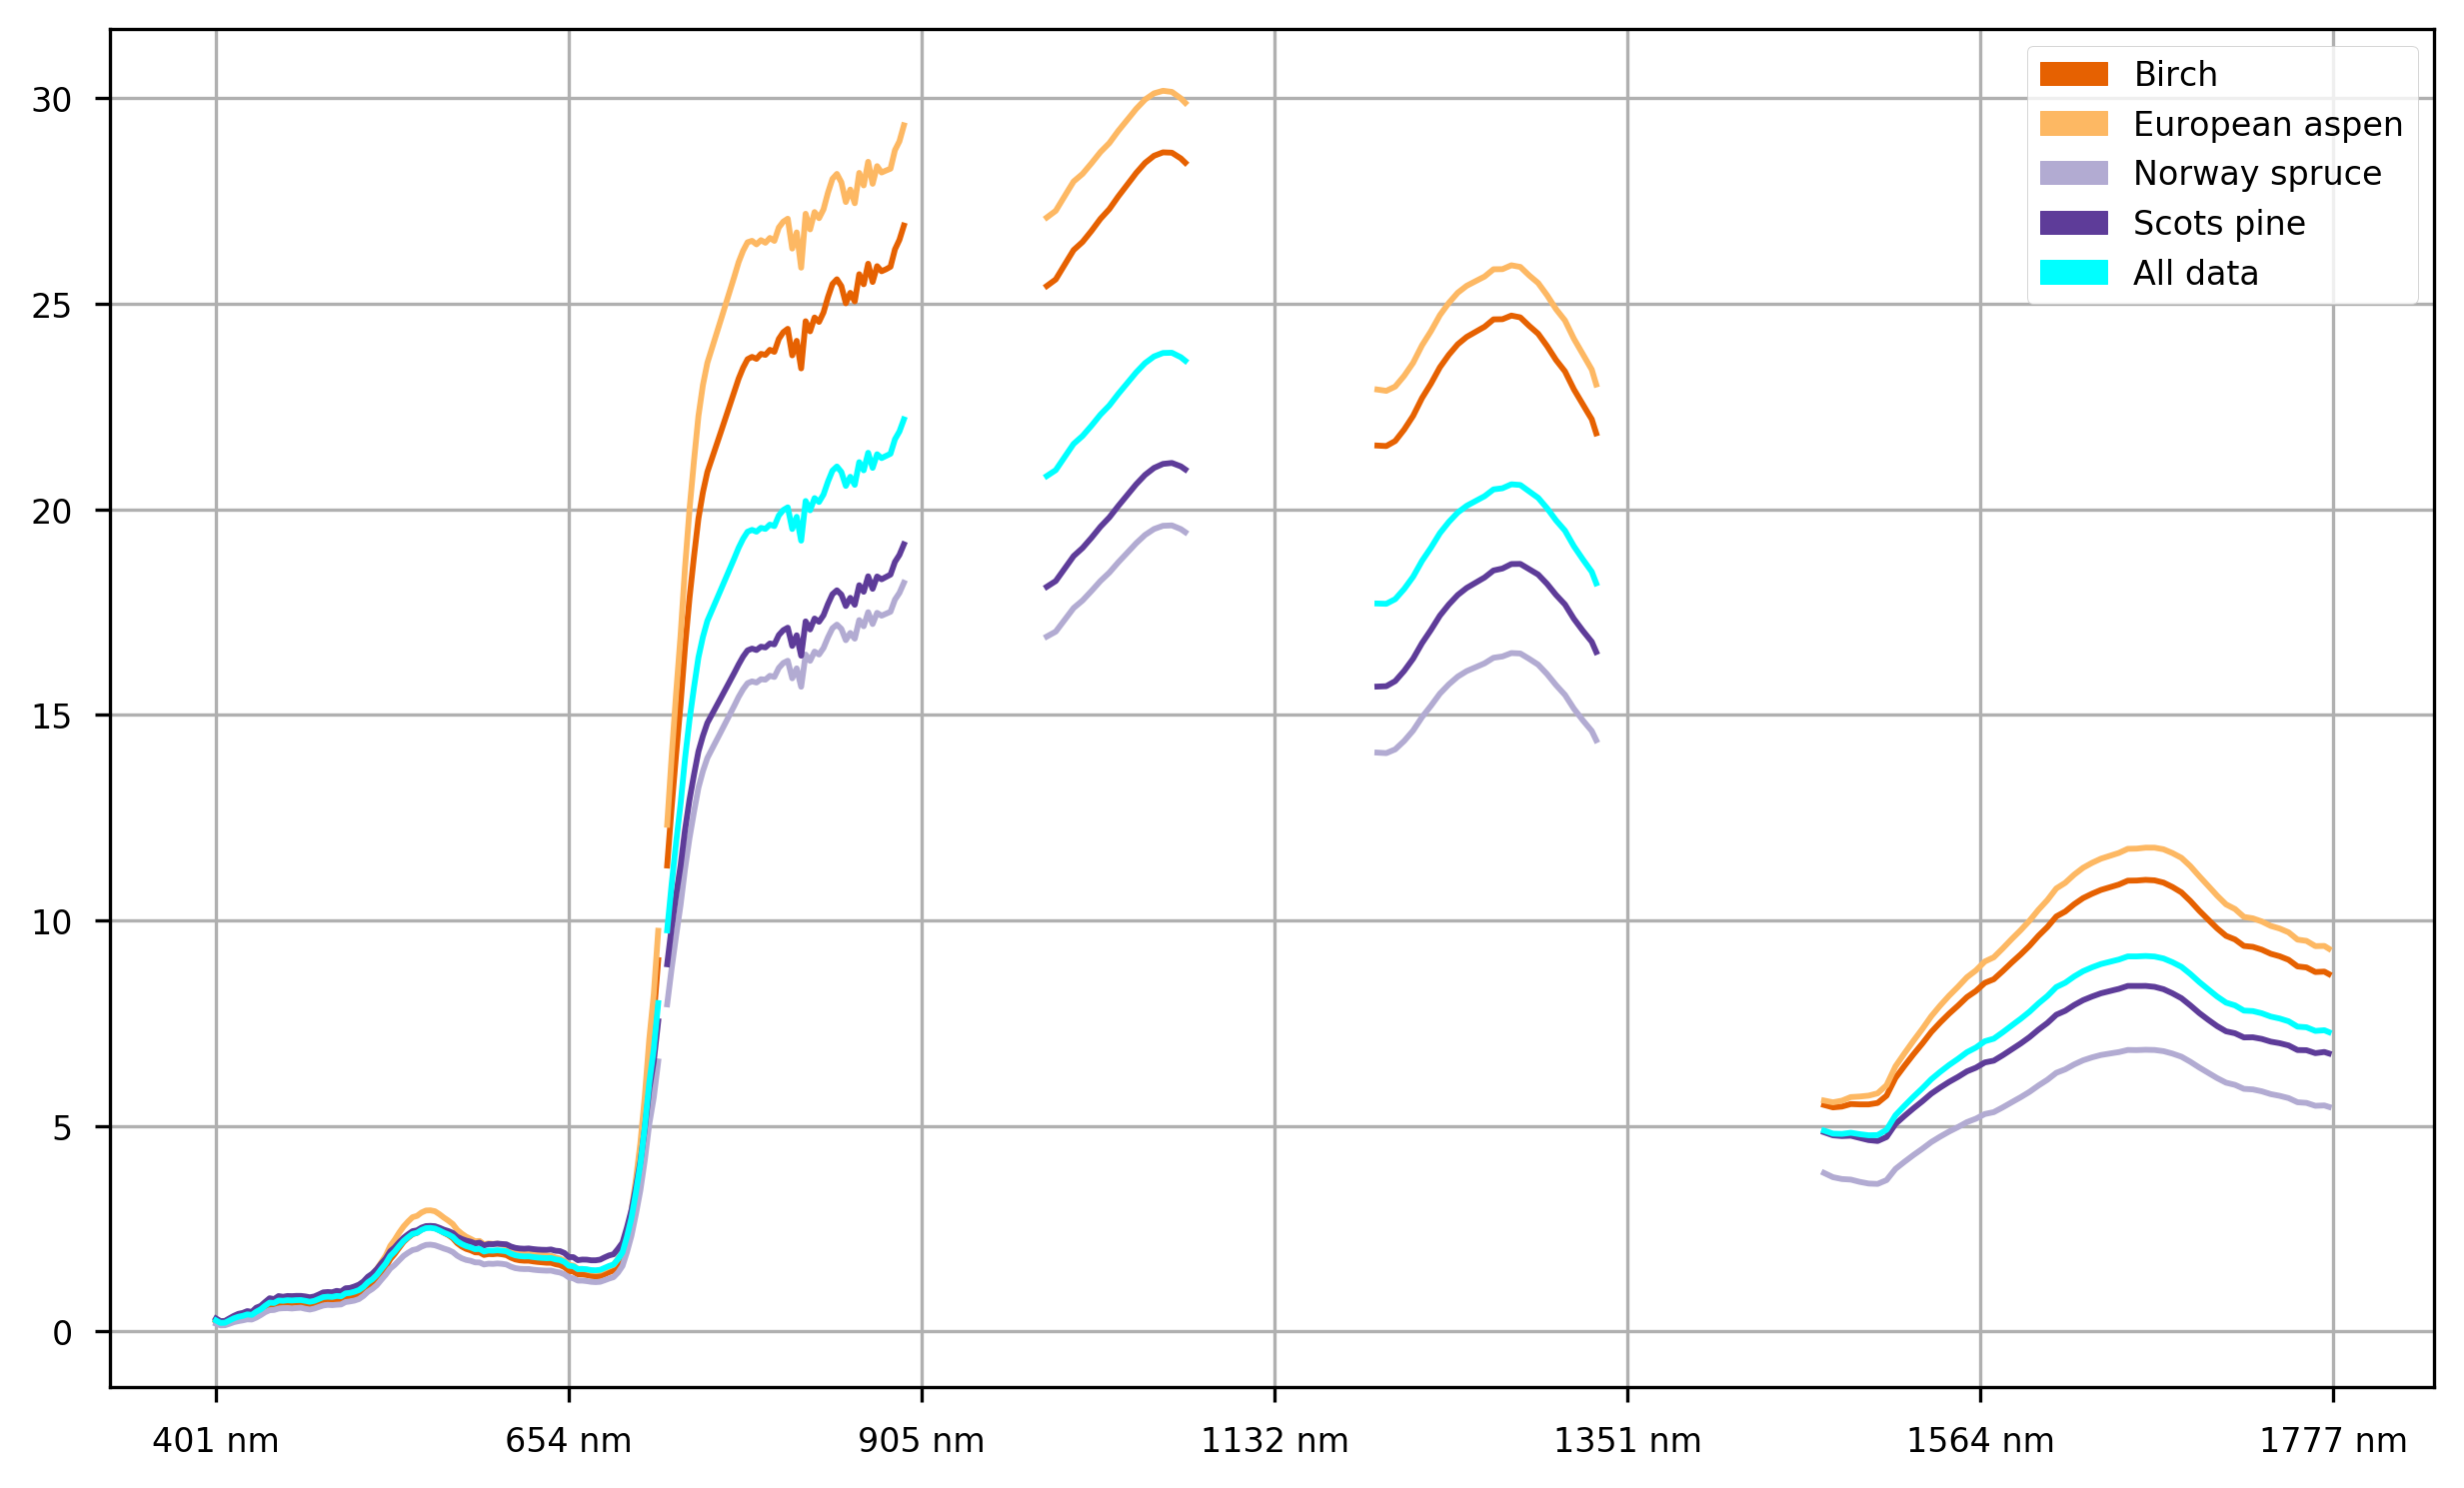

In [35]:
import matplotlib.patches as mpatches
plt.style.use('seaborn-paper')
plt.figure(figsize=(10,6), dpi=300)
#plt.axvline(x=154, c='y')
plot_non_continuous_bands_fix(plt.gca(), birch_means, '#e66101')
plot_non_continuous_bands_fix(plt.gca(), aspen_means, '#fdb863')
plot_non_continuous_bands_fix(plt.gca(), spruce_means, '#b2abd2')
plot_non_continuous_bands_fix(plt.gca(), pine_means, '#5e3c99')
plot_non_continuous_bands_fix(plt.gca(), all_means, 'cyan')

vnir_bws = atm_cor_bandwidths[:186]
swir_bws = atm_cor_bandwidths[193:337]

swir_bws = [bw for bw in swir_bws for _ in range(2)]

sel_bws = list(vnir_bws) + list(swir_bws)
labels = [f'{round(sel_bws[i],0):.0f} nm' for i in np.arange(0, len(sel_bws), step=79)]
labels.append(f'{round(sel_bws[-1],0):.0f} nm')
plt.xticks(np.arange(0, len(sel_bws)+1, step=79), labels, rotation='horizontal')

birch_patch = mpatches.Patch(color='#e66101', label='Birch')
aspen_patch = mpatches.Patch(color='#fdb863', label='European aspen')
spruce_patch = mpatches.Patch(color='#b2abd2', label='Norway spruce')
pine_patch = mpatches.Patch(color='#5e3c99', label='Scots pine')
all_patch = mpatches.Patch(color='cyan', label='All data')
plt.legend(handles=[birch_patch, aspen_patch, spruce_patch, pine_patch, all_patch])
#plt.legend([aspen, pine, spruce, birch, alldata],
#            [#'VNIR and SWIR separator', 
#            f'European aspen (n={aspen_values.shape[0]})', f'Scots pine (n={pine_values.shape[0]})', 
#            f'Norway spruce (n={spruce_values.shape[0]})', f'Birch (n={birch_values.shape[0]})',
#            'All data'])
#plt.title('Average spectra for 4m image patches')
plt.grid()
plt.savefig('mean_spectra_2m.jpg', bbox_inches='tight', transparent=False, dpi=500)
plt.show()

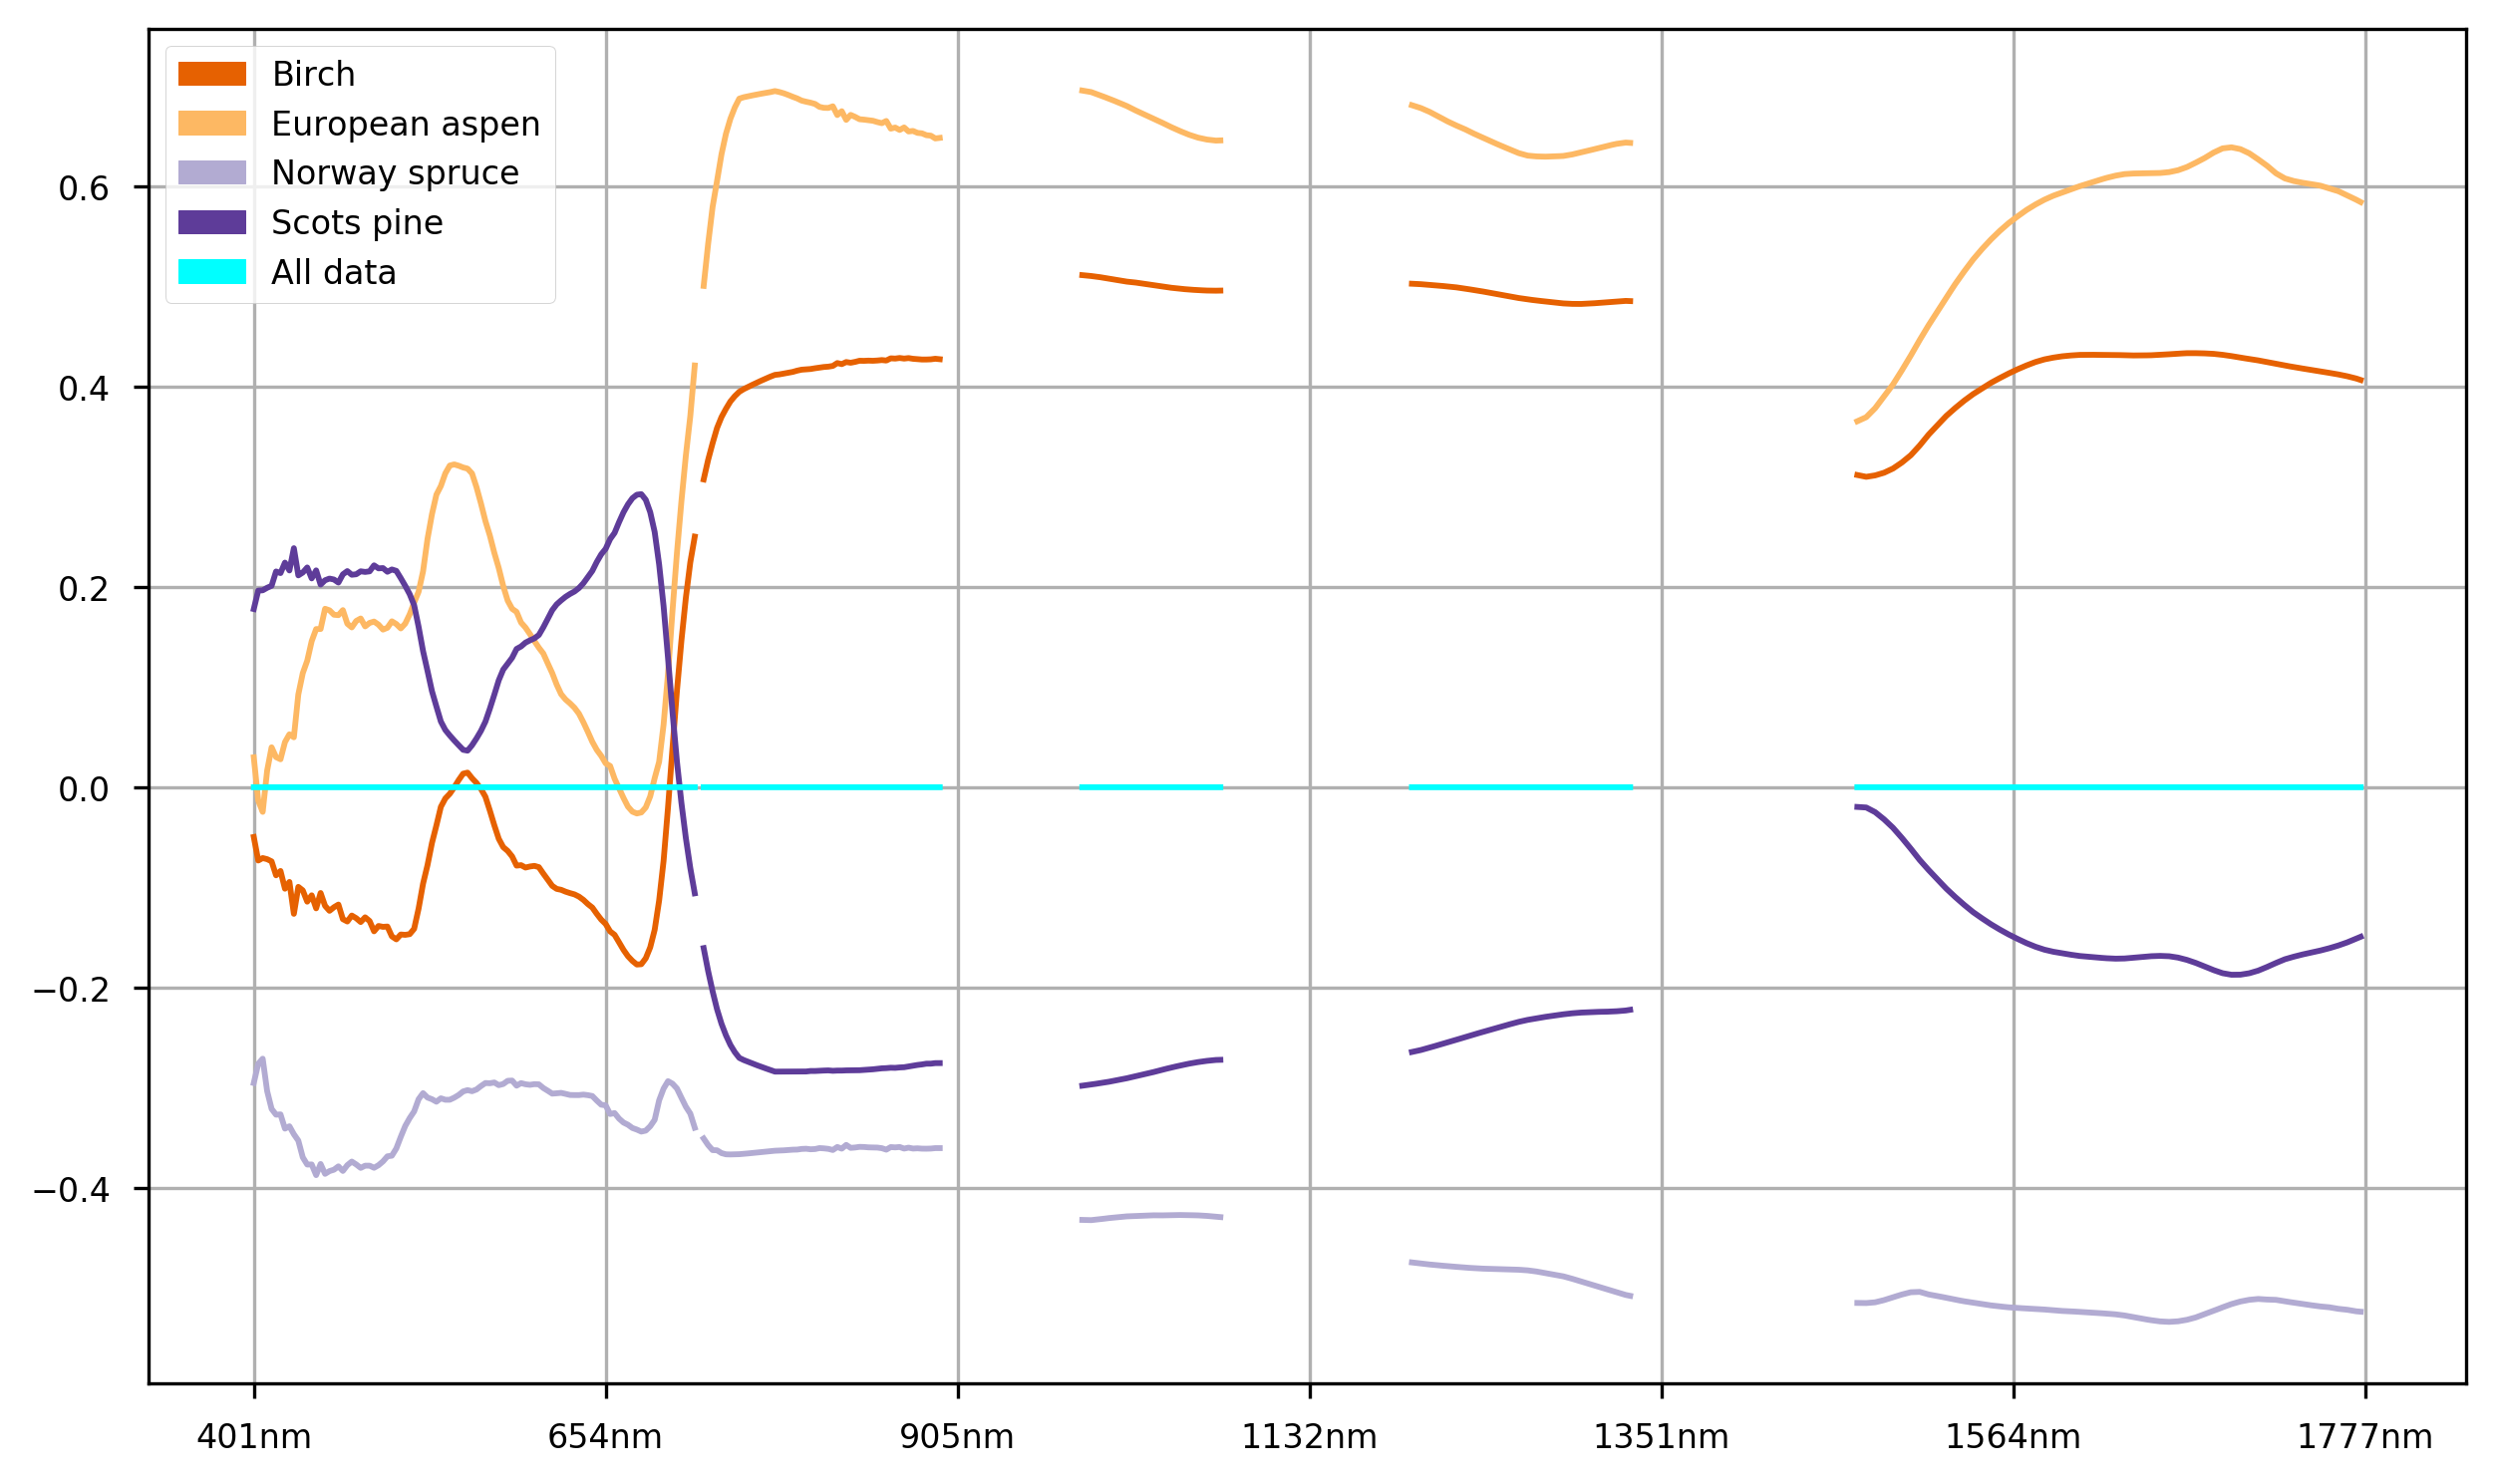

In [39]:
import matplotlib.patches as mpatches
plt.style.use('seaborn-paper')
plt.figure(figsize=(10,6), dpi=300)
train_means = np.nanmean(data_cubes, axis=(0,2,3))
train_std = np.nanstd(data_cubes, axis=(0,2,3))

aspen_values_norm = np.array([(cube - train_means[:,None, None]) / (train_std[:,None,None]) for cube in aspen_values])
pine_values_norm = np.array([(cube - train_means[:,None, None]) / (train_std[:,None,None]) for cube in pine_values])
spruce_values_norm = np.array([(cube - train_means[:,None, None]) / (train_std[:,None,None]) for cube in spruce_values])
birch_values_norm = np.array([(cube - train_means[:,None, None]) / (train_std[:,None,None]) for cube in birch_values])
all_values_norm = np.array([(cube - train_means[:,None, None]) / (train_std[:,None,None]) for cube in data_cubes])
plot_non_continuous_bands_fix(plt.gca(), np.nanmean(birch_values_norm[:,:-1,:,:], axis=(0,2,3)), '#e66101')
plot_non_continuous_bands_fix(plt.gca(), np.nanmean(aspen_values_norm[:,:-1,:,:], axis=(0,2,3)), '#fdb863')
plot_non_continuous_bands_fix(plt.gca(), np.nanmean(spruce_values_norm[:,:-1,:,:], axis=(0,2,3)), '#b2abd2')
plot_non_continuous_bands_fix(plt.gca(), np.nanmean(pine_values_norm[:,:-1,:,:], axis=(0,2,3)), '#5e3c99')
plot_non_continuous_bands_fix(plt.gca(), np.nanmean(all_values_norm[:,:-1,:,:], axis=(0,2,3)), 'cyan')

vnir_bws = atm_cor_bandwidths[:186]
swir_bws = atm_cor_bandwidths[193:337]

swir_bws = [bw for bw in swir_bws for _ in range(2)]

sel_bws = list(vnir_bws) + list(swir_bws)
labels = [f'{round(sel_bws[i],0):.0f}nm' for i in np.arange(0, len(sel_bws), step=79)]
labels.append(f'{round(sel_bws[-1],0):.0f}nm')
plt.xticks(np.arange(0, len(sel_bws)+1, step=79), labels, rotation='horizontal')

    
birch_patch = mpatches.Patch(color='#e66101', label='Birch')
aspen_patch = mpatches.Patch(color='#fdb863', label='European aspen')
spruce_patch = mpatches.Patch(color='#b2abd2', label='Norway spruce')
pine_patch = mpatches.Patch(color='#5e3c99', label='Scots pine')
all_patch = mpatches.Patch(color='cyan', label='All data')
plt.legend(handles=[birch_patch, aspen_patch, spruce_patch, pine_patch, all_patch])
plt.grid()
plt.savefig('mean_spectra_2m_norm_fix.jpg', bbox_inches='tight', transparent=False, dpi=500)
plt.show()